In [1]:
import os
os.chdir("../")

In [2]:
!pwd

/workspaces/example_digital-twin_incubator_twright/software


# Incubator Case Study

In [3]:
from verified_twin.lbuc import *

from sage.symbolic.function_factory import function_factory

from verified_twin.base import *
from verified_twin.parametric_models import ParametricModel
from verified_twin.incubator_models import SwitchingFourParameterModel
from verified_twin.controllers import BasicController, TrivialController, SignalSwitchedController
from verified_twin.simulators import VerifiedContinuousSimulator, DiscreteSimulator, HybridSimulator

In [4]:
var("t, T_S, T_H, T_A, T_F, C_S, C_H, C_A, C_F, I, T_R, G_S, G_H, G_B, G_F, V")

(t, T_S, T_H, T_A, T_F, C_S, C_H, C_A, C_F, I, T_R, G_S, G_H, G_B, G_F, V)

In [5]:
intervalfourpm = SwitchingFourParameterModel([RIF("0"), RIF('25'), RIF('[20.5935,24.5935]')])

In [6]:
fourpm = SwitchingFourParameterModel([RIF("0"), RIF('25'), RIF('22.5935')])

## Parametic model with an abstracted controller

### Most basic

In [7]:
rs = VerifiedContinuousSimulator({'heater_on': False}, fourpm).run(RIF(100), RIF(50)); rs

running for [50.000000000000000 .. 50.000000000000000] ...
running for [50.000000000000000 .. 50.000000000000000] ...


In [8]:
rs.values

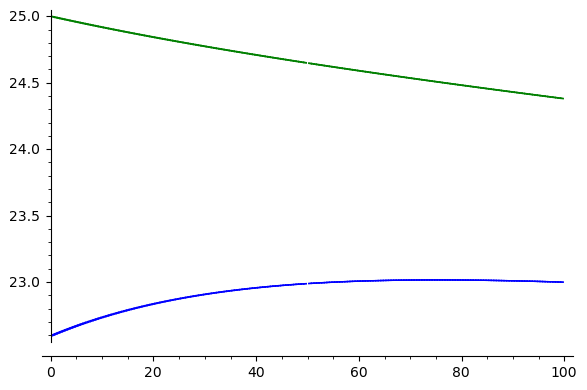

In [9]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

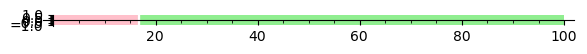

In [13]:
Atomic(T_A > 22.8).signal(rs, symbolic_composition=True).plot()

In [14]:
from verified_twin.traces import RealTimeTrace, HybridTrace, ContinuousTrace, VerifiedContinuousTrace

In [15]:
from functools import reduce

In [16]:
rs = VerifiedContinuousSimulator({'heater_on': True}, fourpm).run(RIF(100), RIF(50)); rs

running for [50.000000000000000 .. 50.000000000000000] ...
running for [50.000000000000000 .. 50.000000000000000] ...


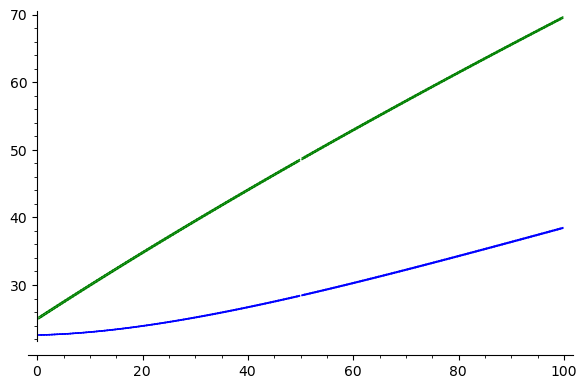

In [17]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

In [19]:
sig = Atomic(T_A > RIF(28)).signal(rs); sig

Signal([0.0000000000000000 .. 100.00000000000000], [([0.0000000000000000 .. 47.553020844737568], False), ([47.553020844776938 .. 100.00000000000000], True)], mask=None)

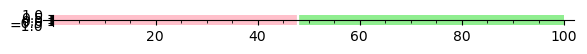

In [20]:
sig.plot()

### Very basic example performing discrete simulation of a trivial controller

In [21]:
ds = DiscreteSimulator(None, TrivialController({}))

In [22]:
import itertools

In [23]:
list(itertools.islice(ds.run_iter(), 5))

[{}, {}, {}, {}, {}]

### Example with a fixed sequence of control decisions

In [24]:
upm = HybridSimulator(fourpm, TrivialController({'heater_on': False}))

In [25]:
fourpm.TraceType

<class 'verified_twin.traces.VerifiedContinuousTrace'>

In [26]:
upm.TraceType

<class 'verified_twin.traces.VerifiedHybridTrace'>

In [27]:
rs = upm.run(RIF(100), RIF(50)); rs

x = [0, 25, 22.59350000000000?]
state = {'heater_on': False}
running for [50.000000000000000 .. 50.000000000000000] ...
x = [50.00000000?, 24.6482301?, 22.9879793?]
state = {'heater_on': False}
running for [50.000000000000000 .. 50.000000000000000] ...


In [28]:
rs.values

[{'heater_on': False},
 {'heater_on': False},
 {'heater_on': False},

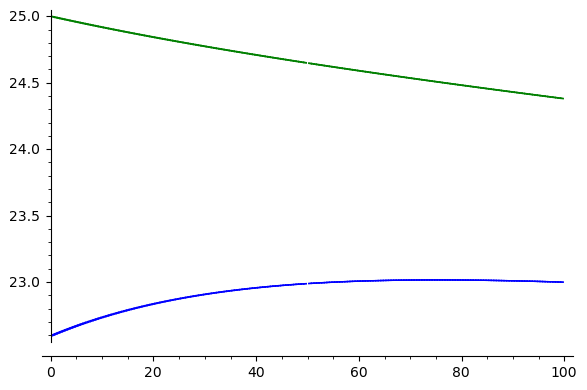

In [29]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

In [30]:
upm = HybridSimulator(fourpm, TrivialController({'heater_on': True}))

In [31]:
rs = upm.run(RIF(100), RIF(50)); rs

x = [0, 25, 22.59350000000000?]
state = {'heater_on': True}
running for [50.000000000000000 .. 50.000000000000000] ...
x = [50.00000000?, 48.5727948?, 28.435182?]
state = {'heater_on': True}
running for [50.000000000000000 .. 50.000000000000000] ...


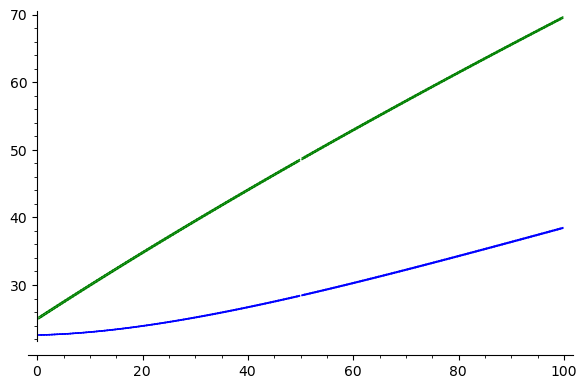

In [32]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

In [33]:
class FixedStepController(BasicController):
    def control_step(self, x, state):
        t = x[0]
        ti = t.center().round()
        print(f"t = {t.str(style='brackets')}")
        print(f"heater_on? = {state['heater_on']}")
        if ti == 0:
            return (RIF("22"), x, dict(heater_on=True))
        elif ti == 22:
            return (RIF("31"), x, dict(heater_on=False))
        elif ti == 53:
            return (RIF("22"), x, dict(heater_on=True))
        elif ti == 75:
            return (RIF("31"), x, dict(heater_on=False))
        elif ti == 106:
            return (RIF("22"), x, dict(heater_on=True))
        elif ti == 128:
            return (RIF("477"), x, dict(heater_on=False))
        else:
            raise Exception(f"These cases should be exhaustive (t = {t})")

In [34]:
fspm = HybridSimulator(fourpm, FixedStepController({'heater_on': False}))

In [35]:
rs = fspm.run(time_limit=RIF("600")); rs

x = [0, 25, 22.59350000000000?]
t = [0.0000000000000000 .. 0.0000000000000000]
heater_on? = False
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [22.000000000?, 35.7616082?, 24.166415?]
t = [21.999999999107494 .. 22.000000000888477]
heater_on? = True
state = {'heater_on': False}
running for [31.000000000000000 .. 31.000000000000000] ...
x = [53.00000000?, 34.6908122?, 26.554256?]
t = [52.999999997581312 .. 53.000000002412968]
heater_on? = False
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [75.00000000?, 45.039103?, 28.599412?]
t = [74.999999996474016 .. 75.000000003514331]
heater_on? = True
state = {'heater_on': False}
running for [31.000000000000000 .. 31.000000000000000] ...
x = [106.00000000?, 43.475171?, 31.21674?]
t = [105.99999999488539 .. 106.00000000508280]
heater_on? = False
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [128.00000000?, 53.51215

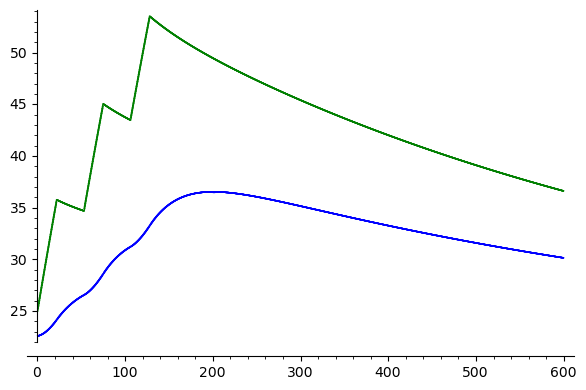

In [36]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

In [37]:
fspm = HybridSimulator(intervalfourpm, FixedStepController({'heater_on': False}))

In [38]:
rs = fspm.run(time_limit=RIF(600))

x = [0, 25, 3.?e1]
t = [0.0000000000000000 .. 0.0000000000000000]
heater_on? = False
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [22.000000000?, 36.?, 3.?e1]
t = [21.999999999107494 .. 22.000000000888477]
heater_on? = True
state = {'heater_on': False}
running for [31.000000000000000 .. 31.000000000000000] ...
x = [53.00000000?, 35.?, 3.?e1]
t = [52.999999997581312 .. 53.000000002412968]
heater_on? = False
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [75.00000000?, 45.?, 29.?]
t = [74.999999996474016 .. 75.000000003514331]
heater_on? = True
state = {'heater_on': False}
running for [31.000000000000000 .. 31.000000000000000] ...
x = [106.00000000?, 44.?, 31.?]
t = [105.99999999488539 .. 106.00000000508280]
heater_on? = False
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [128.00000000?, 54.?, 34.?]
t = [127.99999999376197 .. 128.00000000619247]
heater_on

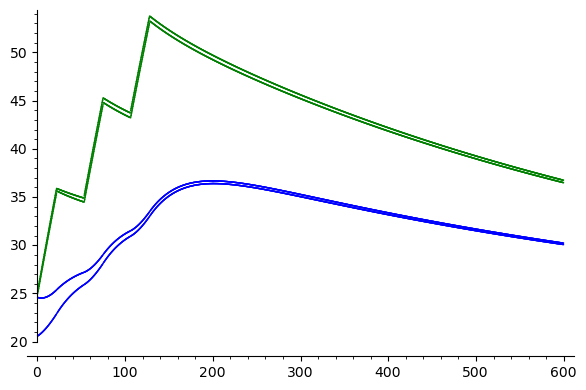

In [39]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

### Generalisation to a signal representing the control decisions

In [40]:
heater_sig = Signal(RIF(0,600),
                    [
                        (RIF("[0, 21.98]"), True),
                        (RIF("[21.99, 52.98]"), False),
                        (RIF("[52.99, 74.98]"), True),
                        (RIF("[74.99, 105.98]"), False),
                        (RIF("[105.99, 127.98]"), True),
                        (RIF("[127.99, 600]"), False)
                    ])

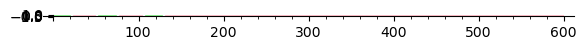

In [41]:
heater_sig.plot()

We want to parameterize the control decisions based on a signal so we can replay any set sequence of control decisions within the model

In [42]:
fspm = HybridSimulator(intervalfourpm, SignalSwitchedController({'heater_on': False}, {'heater_on': heater_sig}))

In [43]:
rs = fspm.run(time_limit=RIF(600))

x = [0, 25, 3.?e1]
state = {'heater_on': True}
running for [21.980000000000000 .. 21.980000000000001] ...
x = [21.980000000?, 36.?, 3.?e1]
state = {'heater_on': False}
running for [30.999999999111565 .. 31.000000000892463] ...
x = [52.98000000?, 35.?, 3.?e1]
state = {'heater_on': True}
running for [21.999999997583152 .. 22.000000003307094] ...
x = [74.98000000?, 45.?, 29.?]
state = {'heater_on': False}
running for [30.999999993173844 .. 31.000000006831542] ...
x = [105.9800000?, 44.?, 31.?]
state = {'heater_on': True}
running for [21.999999991601470 .. 22.000000015246301] ...
x = [127.9800000?, 54.?, 34.?]
state = {'heater_on': False}
running for [472.01999997372257 .. 472.02000001852998] ...


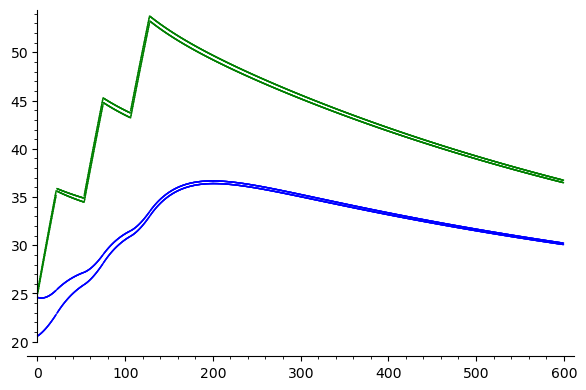

In [44]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

### Periodic Open Loop Controller

In [45]:
from verified_twin.controllers import PeriodicOpenLoopController

In [46]:
fspm = HybridSimulator(
    intervalfourpm,
    PeriodicOpenLoopController(3.0, 10, 1),
    controller_input_map=(lambda x: x[0]),
    controller_output_map=(lambda xin, x: xin),
)

In [47]:
rs = fspm.run(time_limit=RIF(600))

x = [0, 25, 3.?e1]
state = {'heater_on': False, 'current_state': <OpenLoopState.HEATING: 2>}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [3.00000000000?, 25.0?, 3.?e1]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [27.000000000000000 .. 27.000000000000000] ...
x = [30.00000000?, 25.?, 3.?e1]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [33.00000000?, 27.?, 23.?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [27.000000000000000 .. 27.000000000000000] ...
x = [60.00000000?, 26.?, 23.?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [63.00000000?, 28.?, 23.?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [27.000000000000000 .. 27.000000000000000] ...
x = [90.00000000?, 27.?, 

In [48]:
rs.values

[{'heater_on': False, 'current_state': <OpenLoopState.INITIALIZED: 1>},
 {'heater_on': False, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>},
 {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>},
 {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>},
 {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>},
 {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>},
 {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>},
 {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>},
 {'heater_on': False, 'current_state': <OpenLoopSt

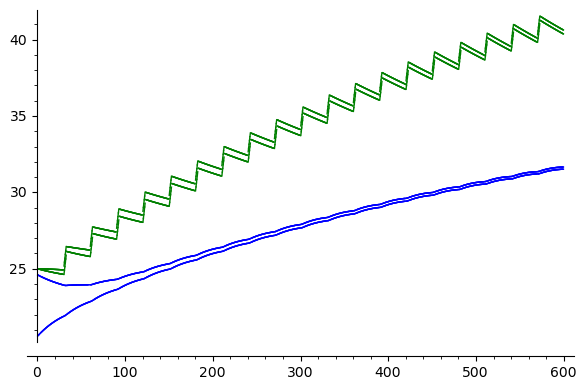

In [49]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

### Using a numpy array of control point samples for callibrator integration

In [50]:
from verified_twin.controllers import SignalArraySwitchedController

In [51]:
import numpy as np

timepoints = np.array([0.0, 22.0, 53.0, 75.0, 106.0, 128.0])
state_arrays = {
    'heater_on': np.array([True, False, True, False, True, False]),
}

In [52]:
controller = SignalArraySwitchedController(
    {'heater_on': False},
    timepoints,
    state_arrays,
)

In [53]:
controller.current_signal_state(21.0, None, timepoints, state_arrays['heater_on'])

True

In [54]:
controller.next_state_update({'heater_on': False}, 0.0)

('heater_on', (0.0, True))

In [55]:
[
    (k, controller.next_signal_change(0.0, False, timepoints, sig_arr))
    for k, sig_arr
    in controller.input_signals_arrays.items()
]

[('heater_on', (0.0, True))]

In [56]:
controller.next_signal_change(1.0, False, timepoints, state_arrays['heater_on'])

(53.0, True)

In [57]:
fspm = HybridSimulator(
    intervalfourpm, controller,
    controller_input_map=(lambda x: x[0]),
    controller_output_map=(lambda xin, x: xin),
)

In [58]:
rs = fspm.run(time_limit=RIF("600")); rs

x = [0, 25, 3.?e1]
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [22.000000000?, 36.?, 3.?e1]
state = {'heater_on': False}
running for [30.999999999111523 .. 31.000000000892506] ...
x = [53.00000000?, 35.?, 3.?e1]
state = {'heater_on': True}
running for [21.999999997583117 .. 22.000000003307165] ...
x = [75.00000000?, 45.?, 29.?]
state = {'heater_on': False}
running for [30.999999993174029 .. 31.000000006831343] ...
x = [106.0000000?, 44.?, 31.?]
state = {'heater_on': True}
running for [21.999999991601654 .. 22.000000015245931] ...
x = [128.0000000?, 54.?, 34.?]
state = {'heater_on': False}
running for [471.99999997372304 .. 472.00000001852971] ...


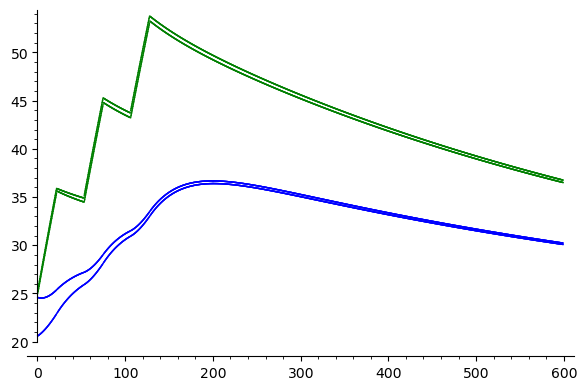

In [59]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

### Now with an actual controller

Now to add in the actual controller in order to trigger the control steps based on the actual system state rather than just looking playing out a fixed sequence of steps...

The controller takes much smaller steps than expected. We should not simply be calculating the next heater turn on time but instead, sampling every $n$ seconds, detecting the conditions to activate the heater, and in this case scheduling the turn on time for a suitable gap in the future. Heater can still turn on again if we do go below the lower bound.

States:
 - *CoolingDown:* the heater has already fired so we wait until we are below the lower bound and turn on if we have gone too low (go to heating)
 - *Heating:* we keep the heater on until next time and turn off afterwards (go to waiting)
 - *Waiting:* We wait until heating gap has elapsed until it can be turned on again. If in_temperature exceeds desired *after next time*, we immediately start heating again. If not, we start waiting again.


In [60]:
from enum import Enum, auto

class IncubatorState(Enum):
    COOLING_DOWN = 'CoolingDown'
    HEATING = 'Heating'
    WAITING = 'Waiting'

In [61]:
class PeriodicBurstIncubatorController(BasicController):
    def __init__(self, initial_state,
                 temperature_desired=RIF("45.0"),
                 lower_bound=RIF("10.0"), heating_time=RIF("0.2"),
                 heating_gap=RIF("0.3")):
        self.temperature_desired = RIF(temperature_desired)
        self.lower_bound = RIF(lower_bound)
        self.heating_time = RIF(heating_time)
        self.heating_gap = RIF(heating_gap)
        self.in_temperature = RIF("20")
        super().__init__(initial_state)

    def control_step(self, xs, state):
        print(f"controller input = {xs}")
        t, x = xs
        new_state = dict(**state)
        
        if state['current_state'] == IncubatorState.COOLING_DOWN:
            new_state['heater_on'] = False
            # if self.in_temperature.upper() <= (self.temperature_desired - self.lower_bound).lower():
            if x <= (self.temperature_desired - self.lower_bound):
                new_state['current_state'] = IncubatorState.HEATING
                new_state['next_time'] = t + RIF(self.heating_time)
        elif state['current_state'] == IncubatorState.HEATING:
            new_state['heater_on'] = True
            if new_state['next_time'] <= t:
                new_state['current_state'] = IncubatorState.WAITING
                new_state['next_time'] = t + RIF(self.heating_gap)
        elif state['current_state'] == IncubatorState.WAITING:
            new_state['heater_on'] = False
            if new_state['next_time'] <= t:
                new_state['current_state'] = IncubatorState.HEATING
                new_state['next_time'] = t + self.heating_time
            else:
                new_state['current_state'] = IncubatorState.COOLING_DOWN
                new_state['next_time'] = None
        else:
            raise Exception("Invalid controller state!")
            
        return (RIF('Inf'), x, new_state)

With control based on the value of the air temperature

In [62]:
fspm = HybridSimulator(
    intervalfourpm,
    PeriodicBurstIncubatorController(
        {'current_state': IncubatorState.COOLING_DOWN, 'next_time': RIF(0), 'heater_on': False},
        heating_time=22, heating_gap=31, temperature_desired=35, lower_bound=10,
    ),
    controller_input_map=(lambda x: (x[0], x[2])),
    controller_output_map=(lambda xin, x: xin),
)

In [63]:
rs = fspm.run(RIF(3000), RIF(3))

x = [0, 25, 3.?e1]
controller input = (0, 3.?e1)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': False}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [3.00000000000?, 25.0?, 3.?e1]
controller input = (3.00000000000?, 3.?e1)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': True}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [6.0000000000?, 26.5?, 3.?e1]
controller input = (6.0000000000?, 3.?e1)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': True}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [9.0000000000?, 28.0?, 3.?e1]
controller input = (9.0000000000?, 3.?e1)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': True}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [12.000000000?, 30.?, 3.?e1]
controller input = (12.000000000?, 3.?e1)
state = {'cur

In [64]:
rs.values

[{'current_state': <IncubatorState.COOLING_DOWN: 'CoolingDown'>,
  'next_time': 0,
  'heater_on': False},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': False},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.WAITING: 'Waiting'>,
  'next_time': 55.000000000?,
  'heater_on': True},
 {'curren

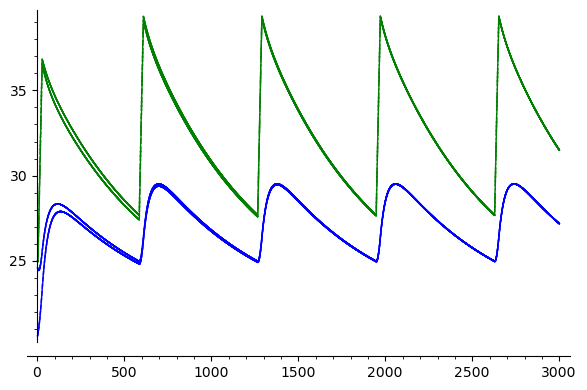

In [65]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

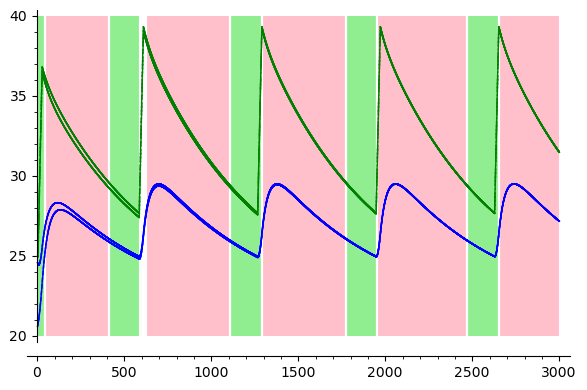

In [73]:
p = (  rs.plot(('T_A', 'T_H'), color=('blue', 'green'))
     + Atomic(T_A < RIF(26)).signal(rs, symbolic_composition=True).plot(y_range=(20, 40)) )
p.set_aspect_ratio('automatic')
p

In G.signal
mask for G = None


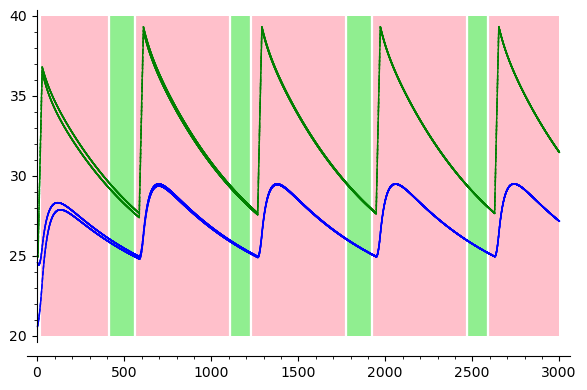

In [77]:
p = (  rs.plot(('T_A', 'T_H'), color=('blue', 'green'))
     + G(RIF(0, 50), Atomic(T_A < RIF(26))).signal(rs, symbolic_composition=True).plot(y_range=(20, 40)) )
p.set_aspect_ratio('automatic')
p

mask for F = None


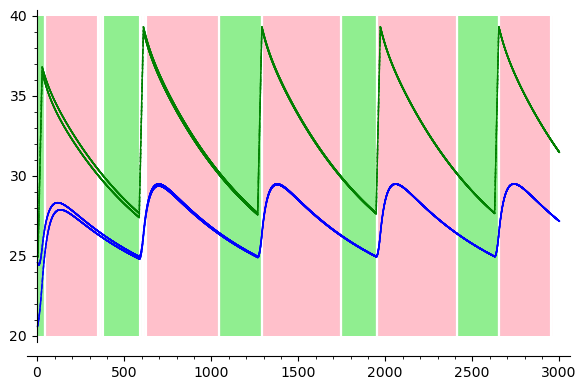

In [78]:
p = (  rs.plot(('T_A', 'T_H'), color=('blue', 'green'))
     + F(RIF(0, 50), Atomic(T_A < RIF(26))).signal(rs, symbolic_composition=True).plot(y_range=(20, 40)) )
p.set_aspect_ratio('automatic')
p

With control based on a fixed input temperature of $20.0$

In [90]:
fspm = HybridSimulator(
    intervalfourpm,
    PeriodicBurstIncubatorController(
        {'current_state': IncubatorState.COOLING_DOWN, 'next_time': RIF(0), 'heater_on': False},
        heating_time=22, heating_gap=31, temperature_desired=35, lower_bound=10,
    ),
    controller_input_map=(lambda x: (x[0], RIF("20.0"))),
    controller_output_map=(lambda xin, x: xin),
)

In [91]:
rs = fspm.run(RIF(3000), RIF(3))

x = [0, 25, 3.?e1]
controller input = (0, 20)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': False}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [3.00000000000?, 25.0?, 3.?e1]
controller input = (3.00000000000?, 20)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': True}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [6.0000000000?, 26.5?, 3.?e1]
controller input = (6.0000000000?, 20)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': True}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [9.0000000000?, 28.0?, 3.?e1]
controller input = (9.0000000000?, 20)
state = {'current_state': <IncubatorState.HEATING: 'Heating'>, 'next_time': 22, 'heater_on': True}
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [12.000000000?, 30.?, 3.?e1]
controller input = (12.000000000?, 20)
state = {'current_state': <I

In [92]:
rs.values

[{'current_state': <IncubatorState.COOLING_DOWN: 'CoolingDown'>,
  'next_time': 0,
  'heater_on': False},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': False},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.HEATING: 'Heating'>,
  'next_time': 22,
  'heater_on': True},
 {'current_state': <IncubatorState.WAITING: 'Waiting'>,
  'next_time': 55.000000000?,
  'heater_on': True},
 {'curren

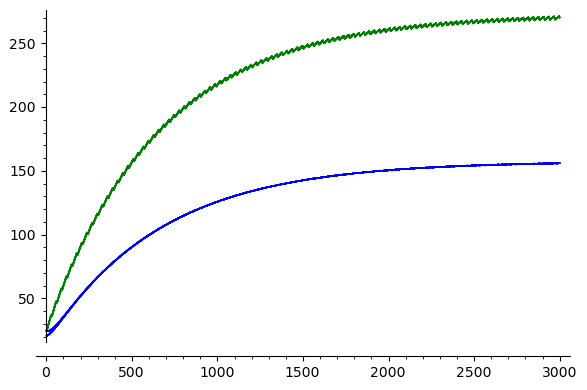

In [93]:
rs.plot(('T_A', 'T_H'), color=('blue', 'green'))

One major issue we have to deal with is jump detection on hybrid transitions. Whilst numerical simulators and my existing code triggers control jumps at the earliest time they can possibly occur, to do things properly, we should consider all of the jumps which could possibly occur, introducing nondeterminism in to the dynamics of the discrete part of the hybrid controller (this is roughly how Flow*  does things). We need to consider to what extent it is necessary to model this complexity in order to model the dynamics of the systems we need to handle.

This consideration will be of crucial importance when using this model as a digital twin, since the running system will not have this same nondeterminism, but rather, will follow one particular sequence of possible control jumps. One option is to use a nondeterminstic controller model for the possible behaviours and then 

Another consideration is the restriction of control jumps to discrete timepoints (e.g. multiples of 3 sec). This is a key divergence between our simulation approach and how most exact hybrid systems simulators work and models an important aspect of how the digital twin will work, however, is this actually a necessary part of our digital twin as a predictive model? For example, could we use standand non-deterministic hybrid model to overapproximate all possible control decision timings?

### Better controller design model

A major problem with the previous method of simulating the controller is that we compute a Flowpipe based on a different (interval) initial set for each stage of the simulation. This means that we we convert the (preconditioned) Taylor models representing the Flowpipe back to intervals for each time-step so the accuracy of the overall verified-integration will be much closer to a classical interval numerical method than to proper TM based methods where TMs are used to track uncertainties over long time windows. The need to handle very long sequences of reach objects and the constant switches between Python and C++ code will also destroy the performance of the overall simulation method.

A better way to simulate the decisions of a particular controller is to calculate a signal for the time windows on which a given control decision can occur and then use this to restrict the time domain of the computed reach sequence to compute all of the possible jump points at which a state transition could occur. This will allow us to use TMs to track the dynamics covering multiple control windows as long as no transitions actually occur, and also suggests a way to handle jumps nondeterminstically. In doing this, we could either, either snap jumps to discrete control intervals or handle as occuring nondeterministically over contrinuous time intervals. Overall, this is not as sophisticated as Flow*'s built in hybrid system handling but should be sufficient for this case study. 

How tightly coupled should we be to the underlying dynamics?

## Attempt at coupled plant modelling

In [94]:
from verified_twin.simulators import NumericalContinuousSimulator
from verified_twin.parametric_models import NumericalParametricModel

In [95]:
numericalsevenpincubator = NumericalParametricModel(
    "T_H,T_A,T_F",
    [QQ(20.0), QQ(20.0), QQ(20.0)],
    [
        (1/C_H)*(V*I - G_H*(T_H - T_A)),
        (1/C_A)*(G_H*(T_H - T_A) - G_B*(T_A - T_R) - G_F*(T_A - T_F)),
        (1/C_F)*G_F*(T_F - T_A),
    ],
    {
        "C_H": QQ(700.0),
        "C_A": QQ(700.0),
        "C_F": QQ(700.0),
        "V":   QQ(0.03),
        "I":   QQ(1.0),
        "T_R": QQ(18.0),
        "G_H": QQ(1.0),
        "G_B": QQ(1.0),
        "G_F": QQ(1.0),
    },
)

In [96]:
rs = NumericalContinuousSimulator({}, numericalsevenpincubator).run(time_limit=QQ(2000))

run_duration = 2000
odes = (-1/700*T_H + 1/700*T_A + 3/70000, 1/700*T_H - 3/700*T_A + 1/700*T_F + 9/350, -1/700*T_A + 1/700*T_F)
running for 2000 ...
x = (20, 20, 20)


In [97]:
rs.values[0]

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 33
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7ff06aab8a90>
   status: 0
  success: True
        t: array([   0.        ,   60.81234345,  121.6246869 ,  255.56922333,
        389.51375975,  523.45829617,  646.39017981,  769.32206345,
        892.25394708,  981.63539405, 1071.01684102, 1160.39828798,
       1271.57486224, 1382.7514365 , 1493.92801077, 1934.74685896,
       2000.        ])
 t_events: None
        y: array([[20, 19.992570021871693, 19.976751762721424, 19.926995273026762,
        19.859355495014327, 19.79234417026471, 19.73899849053494,
        19.69595825665736, 19.664486940503846, 19.649595901569555,
        19.641940810675866, 19.641835549604828, 19.652760611595944,
        19.6765584640304, 19.71397106555425, 20.014893106975936,
        20.08277650684741],
       [20, 19.85987959957853, 19.74963222966928, 19.566985859797832,
      

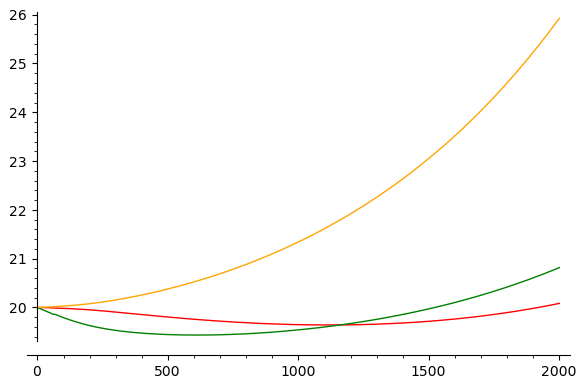

In [98]:
rs.plot((0, 1, 2), color=('red', 'green', 'orange'))